# Building a histogram density estimator with indicator functions

In [1]:
# Load the libraries we'll use
######################################

import numpy as np # Basic numerics
import pandas as pd # Data handling
import matplotlib.pyplot as plt  # Graphics

Before doing anything else, we make sure there's a directory to receive the figures we'll plot.

In [2]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

## Indicator functions

The goal of this notebook is to treat the histogram as a density estimator and explore a representation of that estimator in terms of indicator functions. To this end, we begin by writing a snippet of code that specifies an indicator function $1_{\{A\}}(x)$. Here $A$ is some logical proposition — something that could be true or false — and the indicator function is 1 is $A$ is `True` and 0 if $A$ is `False`.

In [3]:
# An indicator function for the proposition A
def indicator( A ):
    if A is True:
        return( 1 )
    else:
        return( 0 )

### Indicator functions with $A = a \leq x < b$.

All the indicator functions needed to constuct a histogram density estimator ask the question, "Does $x$ lie in a certain interval?", so here we check that works as expected, by asking whether various points lie in the inteval $0 \leq x < 1$.

In [4]:
xVals = np.array([-0.5, 0.5, 1, 1.5]) # Values to test for membership in the interval
funcVals = np.zeros(len(xVals)) # initialise the result
for j in range(len(xVals)):
    x = xVals[j]
    A = bool((0 <= x) and (x < 1))
    funcVals[j] = indicator( A )

# The result here should be [0, 1, 0, 0]
funcVals

array([0., 1., 0., 0.])

## Histogram density estimators

The formula quoted in the lecture notes depends on a set of $q+1$ boundaries $b_0 < b_1 < \dots < b_q$ that specify $q$ bins: the $j$-th bin has $b_{j-1} \leq x < b_j$. The numbering scheme for the $b_j$'s used here is chosen to make the python code more idiomatic. 

### Using indicator functions to find the number of data points in a given bin

Given data, bin boundaries and a bin number $a$, where $a \in \{1, 2, \dots q\}$, the function below uses indicator functions to compute the number of data points that fall into bin number $a$ via the sum $$\sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < q_a \}},$$
which is the rightmost factor in the formula from the lecture notes.

In [5]:
# Here:
#   * a is the number of the bin in question. It is in the range 1 ... q.
#   * x  an array holding the data;
#   * b  an array holding the bin boundaries

def numPointsInBin( a, x, b ):
    # Initialise result
    nPoints = 0 
    
    # Do the sum over the data
    for j in range(len(x)):
        A = bool( (b[a-1] <= x[j]) and (x[j] < b[a]) )
        nPoints += indicator( A )
        
    return( nPoints )
    
# Do a small test. The answer should be 2
xTest = np.array([0.3, 1.1, 1.5, 2.3, 2.8])
bTest = np.array([0, 1, 2, 5 ])
numPointsInBin( 2, xTest, bTest )

2

### Using indicator functions to find the *fraction* of the data that falls in a given bin

This is very similar to the previous section save that we divide by the total number of data points to get a proportion. Using the notation of the lecture, we are computing 
$$\theta_a = \frac{1}{n} \, \sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < b_a \}}$$
where I have introduced the symbol $\theta_a$ to mean the fraction of the data that falls in the $a$-th bin.

In [6]:
def fracDataInBin( a, x, b ):
    # Get the number of data points
    nPtsInData = len(x)
    
    # Exploit our previous work
    nPtsInBin = numPointsInBin( a, x, b )
    return( nPtsInBin / nPtsInData )

# Using the same test data as above, we expect the answer to be 2/5 = 0.4
fracDataInBin( 2, xTest, bTest )

0.4

### Determining the height of the bar above a given bin

In a histogram-based approximation to the density we want the *area* of the $a$-th bar to be $\theta_a$, the fraction of the data that falls in the $a$-th bin. The area of this bar is given by a product $w_a \times h_a = (b_a - b_{a-1}) \times h_a$, where $w_a = (b_a - b_{a-1})$ is the width of the $a$-th bin. Thus, as we want $\theta_a = (b_q - b_{q-1}) \times h_a$, we should take 
$$h_a = \frac{\theta_a}{b_a - b_{a-1}}$$ 
or, in terms of the notation from lecture, 
$$h_a = \frac{1}{b_a - b_{a-1}} \left(\frac{1}{n} \, \sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < b_a \}}\right)$$

**N.B.** If the bins aren't all the same width, then the heights computed here will mean that the density-approximating histogram is *not* just a scaled-down version of the count-based histogram.

In [7]:
def heightOfBar( a, x, b ):
    # Get the area of the bar
    areaOfBar = fracDataInBin( a, x, b )
    
    # Divide the area by the bar's width
    widthOfBar = b[a] - b[a-1]
    return( areaOfBar / widthOfBar )

# The answer should be 0.4
heightOfBar( 2, xTest, bTest  )

0.4

### Using indicator functions to describe a single bar

The tools we've built up so far enable us to work out the height of each bar in a density-approximating histogram. We can now use indicator functions again to define a function that gives the contribution of a single bar to the density approximation. In terms of the notation from the lecture, this is
$$f_a(s) = \frac{1_{\{b_{a-1} \leq s < b_a \}}}{b_a - b_{a-1}} \left(\frac{1}{n} \, \sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < b_a \}}\right)$$
where I have introduced the notation $f_a(s)$ to indicate the contribution to the density approximation from the $a$-th bar.

In [8]:
# Here:
#   * s is a number at which we want to evaluate our bar (considered as a contribution to a density approximation)
#   * a is the number of the bin in question. It is in the range 1 ... q.
#   * x  an array holding the data;
#   * b  an array holding the bin boundaries

def singleBarFunc( s, a, x, b ):
    A = bool((b[a-1] <= s) and (s < b[a]))
    indicatorVal = indicator( A )
    if( A is True ): # If s is inside the a-th bin
        height = heightOfBar(a, x, b)
    else:
        height = 0 # Saves time by skipping the sum over the data
    
    return( indicatorVal * height )

# Do a small test
sVals = np.array([-0.5, 0.5, 1.5, 2.4]) 
funcVals = np.zeros(len(sVals)) # initialise the result
for j in range(len(sVals)):
     funcVals[j] = singleBarFunc( sVals[j], 2, xTest, bTest )

# The answer should be [0, 0, 0.4, 0]
funcVals

array([0. , 0. , 0.4, 0. ])

#### Combining all single-bar contributions to get the whole density estimate.

Finally, we write a function that adds up all the single-bar contributions to evaluate the whole density estimate. In terms of the notation from the lecture, this is
$$
f(s) \; = \; \sum_{a=1}^{q} f_a(s)
\; = \; \sum_{a=1}^{q} \frac{1_{\{b_{a-1} \leq s < b_a \}}}{b_a - b_{a-1}} \left(\frac{1}{n} \, \sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < b_a \}}\right) 
\; = \; \frac{1}{n} \, \sum_{a=1}^{q} \frac{1_{\{b_{a-1} \leq s < b_a \}}}{b_a - b_{a-1}} \left( \sum_{j=1}^n 1_{\{b_{a-1} \leq x_j < b_a \}}\right),
$$
where the rightmost expression is the same as the one from lecture.

In [9]:
# Here:
#   * s is a number at which we want to evaluate the density estimate
#   * x  an array holding the data;
#   * b  an array holding the bin boundaries

def histogramDensityEstimate( s, x, b ):
    # Find the number of bins
    q = len(b) - 1
    
    # Sum up the contributions from the single bars
    hdeVal = 0 ; # hde is short for Histogram Density Estimator
    for a in range(1, (q+1)): # bars are numbered 1, 2, ..., q
        hdeVal += singleBarFunc( s, a, x, b )
    
    return( hdeVal )

## Illustrative plots

We are, at last, in a position to plot an interesting example. Here I'll generate some samples from a distribution over (0,1), then generate a histogram and plot the bars.

In [10]:
# Draw some samples from a beta distribution 
# The recommended way to do this varies with the
# version of numpy
numpyVersionStr = np.__version__
versionStrParts = numpyVersionStr.split('.')

nVals = 1000
myAlpha = 2
myBeta = 4
if( int(versionStrParts[1]) >= 17 ):
    # Do the modern thing
    from numpy.random import default_rng
    myPrng = default_rng()
    xPlot = myPrng.beta( a=myAlpha, b=myBeta, size=nVals )
else:
    # Do the legacy thing
    from numpy import random
    xPlot = np.random.beta( a=myAlpha, b=myBeta, size=nVals )
    
# Choose boundaries for two sets of 20 bins. One set 
# is evenly spaced, while the other set is irregular.
nBins = 20
bPlotRegular = np.linspace( start=0, stop=1, num=(nBins + 1) )
bPlotIrregular = np.sort( np.append( np.random.uniform(size=(nBins-1)), [0,1] ))

### Plotting a single bar

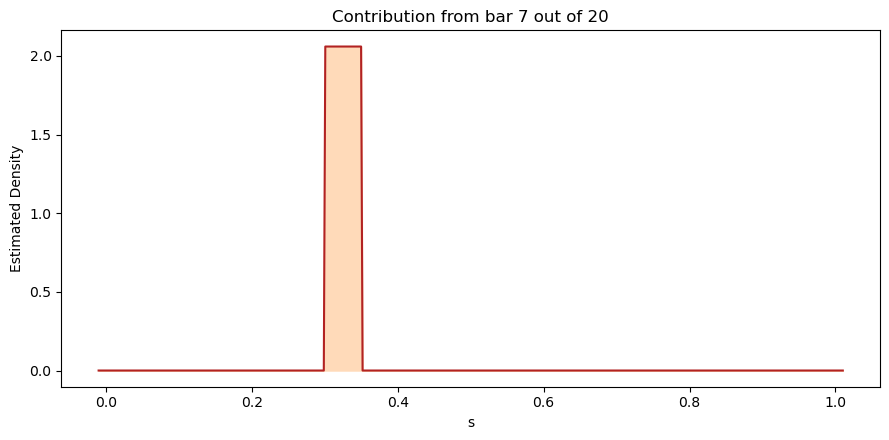

In [11]:
# Set the dimensions of the plot
widthInInches = 9
heightInInches = 4.5
plt.figure( figsize=(widthInInches, heightInInches) )

# Decide which bar we want to plot
a = 7 

# Get a set of values at which we will eavluate our 
# approximte density
sMin = -0.01
sMax = 1.01
nPlotPts = 500
sVals = np.linspace( start=sMin, stop=sMax, num=nPlotPts )

# Evaluate the density
densityVals = np.zeros( nPlotPts )
for j in range(nPlotPts):
    densityVals[j] = singleBarFunc( sVals[j], a, xPlot, bPlotRegular )
    
# Plot the curve
plt.fill_between( sVals, densityVals, color="peachpuff" )
plt.plot( sVals, densityVals, color="firebrick" )

# Add labels
plt.xlabel('s')
plt.ylabel('Estimated Density')
plt.title( "Contribution from bar " + str(a) + " out of " + str(nBins) )
plt.tight_layout()

# Save a PDF version, then display the result here too
plt.savefig('Figures/SingleBar.pdf')
plt.show()

### The whole density estimate: uniformly-sized bins

Here we plot the count-based histogram at left and the density estimate on the right. When, as here, the bins all have the same width, the density estimate is just a vertically rescaled version of the count histogram.

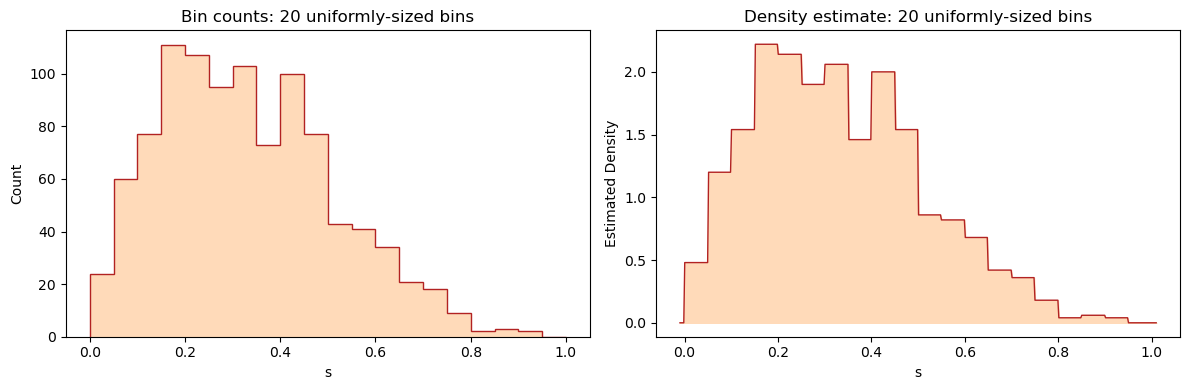

In [12]:
# Set up a pair of plots
widthInInches = 12
heightInInches = 4
hdeFig, hdeAxes = plt.subplots(1, 2, figsize=[widthInInches, heightInInches])

# Evaluate the density
densityVals = np.zeros( nPlotPts )
for j in range(nPlotPts):
    densityVals[j] = histogramDensityEstimate( sVals[j], xPlot, bPlotRegular )
    
# Plot a count-based histogram at left
hdeAxes[0].hist( xPlot, bins=bPlotRegular, color="peachpuff" )
hdeAxes[0].hist( xPlot, bins=bPlotRegular, histtype="step", lw=1, fill=False, color="firebrick" )
hdeAxes[0].set_xlabel('s')
hdeAxes[0].set_ylabel('Count' )
hdeAxes[0].set_title( "Bin counts: " + str(nBins) + " uniformly-sized bins"  )

# Plot our histogram density estimator at right
hdeAxes[1].fill_between( sVals, densityVals, color="peachpuff") 
hdeAxes[1].plot( sVals, densityVals, color="firebrick", lw=1 )
hdeAxes[1].set_xlabel('s')
hdeAxes[1].set_ylabel('Estimated Density' )
hdeAxes[1].set_title( "Density estimate: " + str(nBins) + " uniformly-sized bins"  )

# Save a PDF version, then display the result here too
plt.tight_layout()
plt.savefig('Figures/DensityEstimate_w_UniformBins.pdf')
plt.show()

### The whole density estimate: irregularly-sized bins

When the bins all have different widths the density estimate is not so simply related to the count histogram.

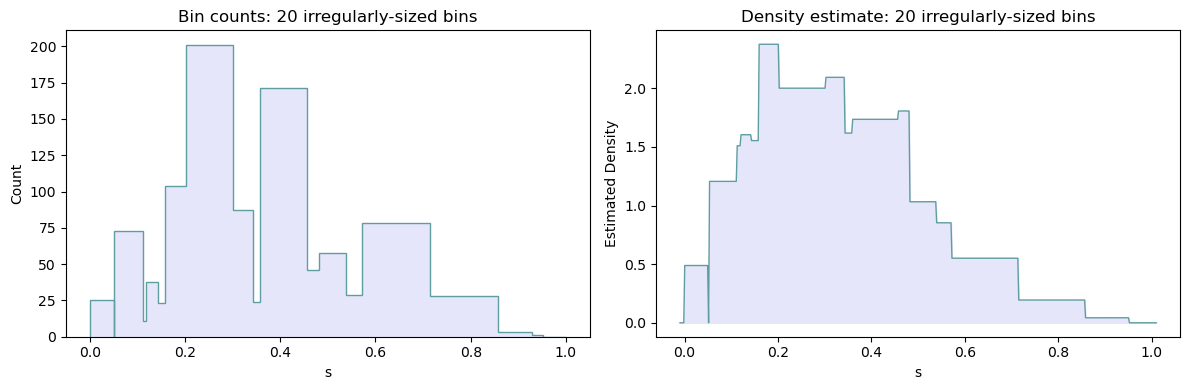

In [13]:
# Set up a pair of plots
widthInInches = 12
heightInInches = 4
hdeFig, hdeAxes = plt.subplots(1, 2, figsize=[widthInInches, heightInInches])

# Evaluate the density
densityVals = np.zeros( nPlotPts )
for j in range(nPlotPts):
    densityVals[j] = histogramDensityEstimate( sVals[j], xPlot, bPlotIrregular )
    
# Plot a count-based histogram at left
hdeAxes[0].hist( xPlot, bins=bPlotIrregular, color="lavender" )
hdeAxes[0].hist( xPlot, bins=bPlotIrregular, histtype="step", lw=1, fill=False, color="cadetblue" )
hdeAxes[0].set_xlabel('s')
hdeAxes[0].set_ylabel('Count' )
hdeAxes[0].set_title( "Bin counts: " + str(nBins) + " irregularly-sized bins"  )

# Plot our histogram density estimator at right
hdeAxes[1].fill_between( sVals, densityVals, color="lavender") 
hdeAxes[1].plot( sVals, densityVals, color="cadetblue", lw=1 )
hdeAxes[1].set_xlabel('s')
hdeAxes[1].set_ylabel('Estimated Density' )
hdeAxes[1].set_title( "Density estimate: " + str(nBins) + " irregularly-sized bins"  )

# Save a PDF version, then display the result here too
plt.tight_layout()
plt.savefig('Figures/DensityEstimate_w_IrregularBins.pdf')
plt.show()